In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt 

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2 

In [5]:
%matplotlib inline

In [6]:
import pathlib

In [7]:
CWD = pathlib.Path.cwd()

In [8]:
import sys

In [9]:
import time

In [10]:
sys.path.append('../../ml4seas/')

In [11]:
import numpy as np 
import pandas as pd 
import xarray as xr

In [12]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [13]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [14]:
from NN import *

### some parameters for the model and the logs 

In [15]:
if len(tf.config.list_physical_devices('GPU')) >= 1: 
    compute = 'GPU'
else: 
    compute = 'CPU'

In [16]:
print(f"using the {compute}")

using the GPU


In [17]:
batch_size=32

In [18]:
padd = 8

In [19]:
input_shape = (181, 360, 1) # last for the number of channels 

In [28]:
resize_shape = (padd * round(input_shape[0]/padd), padd * round(input_shape[1]/padd)) # to be evenly divided by the padd

In [29]:
resize_shape

(184, 360)

In [30]:
n_epochs = 20 # number of epochs 

### list the files 

In [31]:
dpath = pathlib.Path('/media/nicolasf/END19101/data/GCMs/processed/hindcasts/CDS/ECMWF/T2M/')

In [32]:
lfiles = list(dpath.glob("ECMWF_T2M_seasonal_anomalies_????_??.nc"))

In [33]:
lfiles.sort()

In [34]:
dset = xr.open_mfdataset(lfiles, concat_dim='time', combine='nested', parallel=True)

In [35]:
dset

,Array,Chunk
Bytes,6.91 kB,24 B
Shape,"(288, 3)","(1, 3)"
Count,1148 Tasks,288 Chunks
Type,datetime64[ns],numpy.ndarray
,Array,Chunk
Bytes,5.63 GB,19.55 MB
Shape,"(288, 25, 3, 181, 360)","(1, 25, 3, 181, 360)"
Count,1152 Tasks,288 Chunks
Type,float32,numpy.ndarray


### selects the training set 

In [36]:
dset_train = dset.sel(time=slice('1993','2010'))

In [37]:
dset_val = dset.sel(time=slice('2011',None))

### select one step (leadtime = 3 months), and only t2m 

In [38]:
dset_train = dset_train[['t2m']].sel(step=3)

In [39]:
dset_val = dset_val[['t2m']].sel(step=3)

### concatenate all the members long the first dimension, to increase number of instances 

In [40]:
dset_train = dset_train.stack(instance=('time','member'))

In [41]:
dset_val = dset_val.stack(instance=('time','member'))

### get the repeated datetimes (will be useful to sample repeatedly in Yds)

In [42]:
rdatetimes_train = dset_train.indexes["instance"].get_level_values(0)

In [43]:
rdatetimes_val = dset_val.indexes["instance"].get_level_values(0)

### transpose to have the instances as the first dimension 

In [44]:
dset_train = dset_train.transpose('instance','lat','lon')

In [45]:
dset_val = dset_val.transpose('instance','lat','lon')

### Generate data for tensorflow 

In [46]:
data_train = XrDataGenerator(dset_train, dset_train, {'t2m':None}, 't2m', norm=True, batch_size=batch_size, mean=None, std=None, shuffle=True, load=False)

In [47]:
data_val = XrDataGenerator(dset_val, dset_val, {'t2m':None}, 't2m', norm=True, batch_size=batch_size, mean=data_train.mean, std=data_train.std, shuffle=True, load=False)

### checks the shape (should be (batch_size, (input_shape), channels)) 

In [48]:
data_train[0][0].shape

(32, 181, 360, 1)

In [49]:
data_val[0][0].shape

(32, 181, 360, 1)

### build the model 

In [50]:
from numba import cuda
device = cuda.get_current_device(); 
device.reset()

In [52]:
# Input placeholder
original = Input(shape=input_shape)

# Resize to have dimensions divisible by 8
resized = ResizeLayer(newsize=resize_shape)(original)

# # Wrap-around in longitude for periodic boundary conditions

padded = PeriodicPadding2D(padd)(resized)

# Encoding layers
x = Conv2D(16, (3, 3), padding='same')(padded)
x = LeakyReLU()(x)
x = Conv2D(8, (3, 3), strides= (2,2), padding='valid')(x)
x = LeakyReLU()(x)
x = Conv2D(8, (3, 3), strides= (2,2), padding='valid')(x)
x = LeakyReLU()(x)
x = Conv2D(8, (3, 3), strides= (2,2), padding='valid')(x)
x = LeakyReLU()(x)

encoded = x

# Decoding layers
x = Conv2DTranspose(8, (3, 3),  strides= (2,2), padding='valid')(encoded)
x = LeakyReLU()(x)
x = Conv2DTranspose(8, (3, 3),  strides= (2,2), padding='valid')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(8, (3, 3),  strides= (2,2), padding='valid')(x)
x = LeakyReLU()(x)
decoded = Conv2D(1, (3, 3), padding='same')(x)

# Strip the longitude wrap-around
pruned = PrunePeriodicPadding2D(padd)(decoded)

outsize = ResizeLayer(newsize=input_shape[:2])(pruned)


In [53]:
autoencoder = Model(original,outsize)

In [54]:
autoencoder.summary(line_length=120)

Model: "model"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
input_2 (InputLayer)                                  [(None, 181, 360, 1)]                           0                 
________________________________________________________________________________________________________________________
resize_layer (ResizeLayer)                            (None, 184, 360, 1)                             0                 
________________________________________________________________________________________________________________________
periodic_padding2d (PeriodicPadding2D)                (None, 200, 376, 1)                             0                 
________________________________________________________________________________________________________________________
conv2d (Conv2D)  

### build the callbacks 

In [55]:
run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")

### checkpoint 

In [56]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(f"./autoencoder_checkpoint_{run_id}_{compute}_fullCNN.h5", save_best_only=True)

### early stopping 

In [57]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [58]:
import os

In [59]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [60]:
def get_run_logdir(run_id):
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir(run_id)
run_logdir

'./my_logs/run_2020_08_10-16_10_41'

In [61]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [62]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

### compile 

In [63]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [64]:
autoencoder.summary(line_length=120)

Model: "model"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
input_2 (InputLayer)                                  [(None, 181, 360, 1)]                           0                 
________________________________________________________________________________________________________________________
resize_layer (ResizeLayer)                            (None, 184, 360, 1)                             0                 
________________________________________________________________________________________________________________________
periodic_padding2d (PeriodicPadding2D)                (None, 200, 376, 1)                             0                 
________________________________________________________________________________________________________________________
conv2d (Conv2D)  

### fit 

### Note: run tensorboard with: 
        
```
tensorboard --logdir=./my_logs  --port=6006
```
<hr>

In [65]:
# autoencoder.fit_generator(generator=data_train,
#                     validation_data=data_val,
#                     use_multiprocessing=True,
#                     workers=6,epochs=n_epochs, 
#                     callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

In [66]:
history = autoencoder.fit(data_train, validation_data=data_val, epochs=n_epochs, callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/20
169/169 [==============================] - 63s 371ms/step - loss: 0.3977 - val_loss: 0.0967
Epoch 2/20
169/169 [==============================] - 60s 353ms/step - loss: 0.0754 - val_loss: 0.0642
Epoch 3/20
169/169 [==============================] - 62s 367ms/step - loss: 0.0595 - val_loss: 0.0566
Epoch 4/20
169/169 [==============================] - 61s 358ms/step - loss: 0.0523 - val_loss: 0.0489
Epoch 5/20
169/169 [==============================] - 59s 351ms/step - loss: 0.0456 - val_loss: 0.0442
Epoch 6/20
169/169 [==============================] - 60s 353ms/step - loss: 0.0423 - val_loss: 0.0417
Epoch 7/20
169/169 [==============================] - 59s 351ms/step - loss: 0.0401 - val_loss: 0.0398
Epoch 8/20
169/169 [==============================] - 60s 354ms/step - loss: 0.0385 - val_loss: 0.0385
Epoch 9/20
169/169 [==============================] - 60s 353ms/step - loss: 0.0371 - val_loss: 0.0371
Epoch 10/20
169/169 [==============================] - 60s 352ms/step - l

### save model 

In [67]:
saved_model = CWD / f"saved_autoencoder_{run_id}_{n_epochs}_epochs_{compute}_fullCNN" 

In [68]:
keras.models.save_model(autoencoder, saved_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/nicolasf/research/Smart_Ideas/code/models/CNN/saved_autoencoder_run_2020_08_10-16_10_41_20_epochs_GPU_fullCNN/assets


### save history file 

In [69]:
import pickle

In [70]:
saved_history = CWD / f"saved_history_{run_id}_{n_epochs}_epochs_{compute}.pkl" 

In [71]:
pickle.dump(autoencoder.history.history, open(saved_history, "wb"))

### Some plots 

### validation data first batch 

In [72]:
data_val[0][0].shape

(32, 181, 360, 1)

### take one from the batch 

In [73]:
i = 10

In [74]:
X = data_val[0][0][i:i+1,:,:,:]

In [75]:
X.shape

(1, 181, 360, 1)

In [76]:
pred = autoencoder.predict(X)

In [77]:
pred.shape

(1, 181, 360, 1)

In [78]:
pred = pred.squeeze()

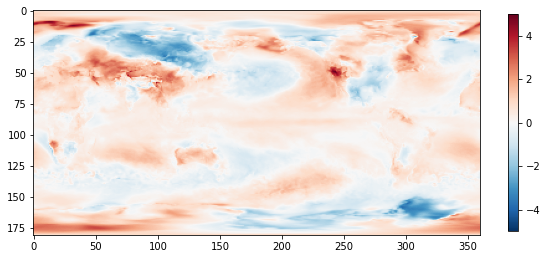

In [79]:
f, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(data_val[0][0][i,::-1,:,0], vmin=-5, vmax=5, cmap=plt.cm.RdBu_r)
plt.colorbar(im, shrink=0.4)

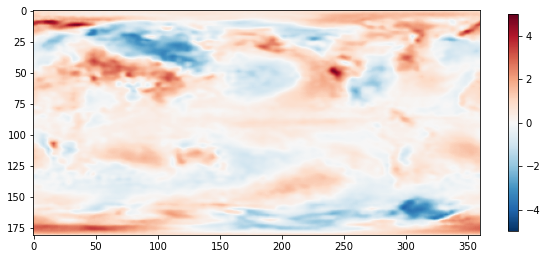

In [80]:
f, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(pred[::-1,:], vmin=-5, vmax=5, cmap=plt.cm.RdBu_r)  
plt.colorbar(im, shrink=0.4)

### Plots the training and validation loss 

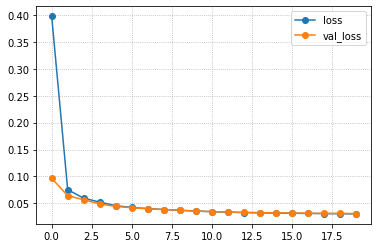

In [81]:
f, ax = plt.subplots()
pd.DataFrame(history.history).plot(ax=ax, marker='o')
ax.grid(ls=':')

In [82]:
pd.DataFrame(history.history)

,loss,val_loss
0,0.397713,0.096706
1,0.075403,0.064170
2,0.059488,0.056641
3,0.052319,0.048877
4,0.045604,0.044217
5,0.042275,0.041705
6,0.040108,0.039840
7,0.038503,0.038482
8,0.037059,0.037065
9,0.035663,0.035623
